In [41]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [2]:
target_func = lambda x: (x - 0.7) * (x + 0.2) - 0.5

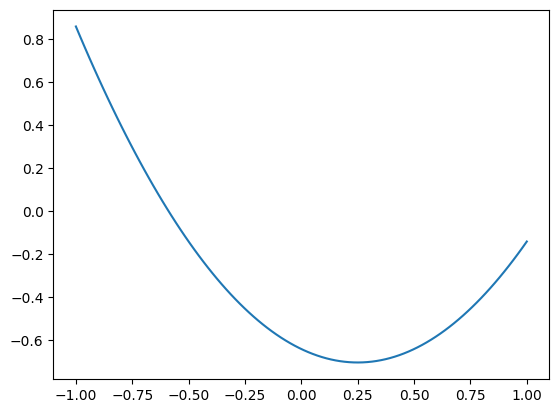

In [3]:
xs = np.linspace(-1, 1, 100)
ys = target_func(xs)
plt.plot(xs, ys)

In [4]:
def generate_func_(model, tfunc):
    xs = np.linspace(-1, 1, 201)
    ys = tfunc(xs)
    ymax = ys.max()
    ymin = ys.min()
    yrange = ymax - ymin
    yshift = (ymax - ymin) / 2
    mtfunc = lambda x: (tfunc(x) - yshift) / yrange
    defunc = lambda y: y * yrange + yshift 
    
    def fn(param):
        model()
        

In [53]:
def generate_func(model, data, shots=100):
    sim = AerSimulator()
    xs, ys = data
    def fn_(param, x, y):
        embetted = model(param, x)
        job = transpile(embetted, sim)
        res = sim.run(job, shots=shots).result().get_counts()
        p = 1 * res.get("0", 0) - 1 * res.get("1", 0)
        p = p / shots
        e = p - y
        return 0.5 * e ** 2
    
    def fn(params):
        errors = [fn_(params, x, y) for x, y in zip(xs, ys)]
        return np.mean(errors)
    
    return fn

In [54]:
rx = lambda qc, angle, target_bit: qc.rx(angle, target_bit)
ry = lambda qc, angle, target_bit: qc.ry(angle,target_bit)
rz = lambda qc, angle, target_bit: qc.rz(angle,target_bit)
cx = lambda qc, target1, target2: qc.cx(target1, target2)
cz = lambda qc, target1, target2: qc.cz(target1, target2)

In [59]:
def build_circuit():
    nq = 1
    nl = 1
    gates = np.asarray([[rx, ry, rz], ] * nq * nl).T.flatten()
    indices = np.hstack([np.arange(nq), ] * len(gates))
    init_params = np.random.random(len(indices)) * 2 - 1
    
    def m(params, x, qc=None):
        if qc is None:
            qc = QuantumCircuit(nq, 1)
        for i in range(nq):
            qc.rx(x, i)
        for g, p, i in zip(gates, params, indices):
            g(qc, p, i)
        qc.measure(0, 0)
        return qc
    return m, init_params


In [60]:
xs = np.random.random(10) * 2 - 1
ys = target_func(xs)
print(xs, ys)

[ 0.56672634 -0.3985192  -0.53216946  0.34664336 -0.28531726 -0.3655528
  0.08578735 -0.31620179  0.02005054 -0.6816499 ] [-0.60218443 -0.28192285 -0.09071093 -0.69316006 -0.41593543 -0.32359475
 -0.67553421 -0.38191553 -0.64962325  0.16547155]


In [62]:
model, params = build_circuit()
bounds = ((-np.pi, np.pi), ) * len(params)
tf = generate_func(model, (xs, ys))
res = minimize(tf, params, method="SLSQP", bounds=bounds)
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.4588388774093617
       x: [ 9.753e-01 -5.491e-01 -5.387e-01]
     nit: 8
     jac: [-1.179e+06 -5.292e+05 -5.814e+05]
    nfev: 46
    njev: 4

In [66]:
params_trained = res.x

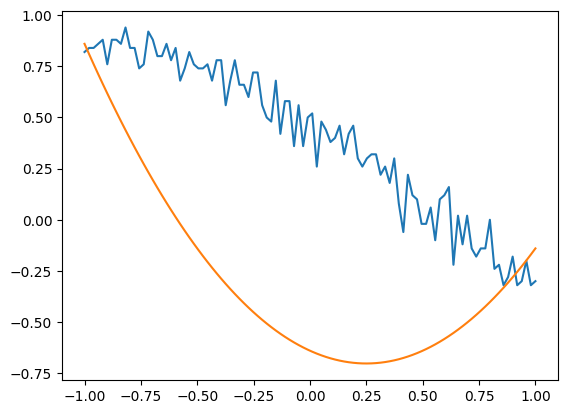

In [70]:
txs = np.linspace(-1, 1, 100)
tys = []

sim = AerSimulator()
for x in txs:
    m = model(params_trained, x)
    job = transpile(m, sim)
    res = sim.run(job, shots=100).result().get_counts()
    y = 1 * res.get("0", 0) - 1 * res.get("1", 0)
    tys.append(y / 100)

labels = target_func(txs)
tys = np.asarray(tys)
plt.plot(txs, tys)
plt.plot(txs, labels)